# Aprendizaje sin supervisión

In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


La mayoría de los datos disponibles en el mundo real no tienen etiquetas. Hay que aplicar métodos que no requieren supervisión

Hemos visto un ejemplo de un método así: reducción de dimensionalidad.

Ahora veremos:

* *Clustering*: agrupar instancias similares en cúmulos.
* Detección de anomalías: aprender como son datos "normales" para detectar datos "raros" (*outliers*).
* Estimación de densidad: estimar la función de densidad de probabilidad del proceso aleatorio que generó el conjunto de datos. Útil para detección de anomalías, analisis y visualización.

## *Clustering*

![](figures_sin_supervision/fig9-1.png)

Sin etiquetas es difícil separar los cúmulos de puntos. En este caso hay más *features* que ayudan con encontrar una buena separación.

### K-Means

![](figures_sin_supervision/fig9-2.png)

*K-Means* funciona bastante bien con datos así, puede encontrar los cúmulos rápidamente.

In [16]:
from sklearn.datasets import make_blobs

In [5]:
blob_centers = array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = array([0.4, 0.3, 0.1, 0.1, 0.1])

In [6]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

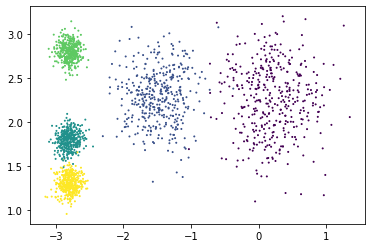

In [7]:
scatter(X[:, 0], X[:, 1], c=y, s=1)

In [14]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

NameError: name 'X' is not defined

In [9]:
y_pred

array([0, 4, 1, ..., 2, 1, 4], dtype=int32)

El algoritmo asigna etiquetas a los puntos según los cúmulos que identifica.

Podemos ver los centros de los $5$ cúmulos:

In [10]:
kmeans.cluster_centers_

array([[-2.80095255,  1.30278669],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80334072,  1.80296136]])

Podemos asignar instancias nuevas al cúmulo más cerca:

In [11]:
X_new = array([[0,2],[3,2],[-3,3],[-3,2.5]])

In [12]:
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

Una visualización de los límites de decisión del método resulta en una **teselación de Voronoi**.

![](figures_sin_supervision/fig9-3.png)

La gran mayoría de las instancias están asignadas al cúmulo correcto, pero algunas no.

Podemos ver las distancias entre cada instancia y los centros de los cúmulos con el método `transform()`.

In [13]:
kmeans.transform(X_new)

array([[2.88642367, 0.32995317, 2.9042344 , 1.49439034, 2.81025683],
       [5.84270116, 2.80290755, 5.84739223, 4.4759332 , 5.80668475],
       [1.70884549, 3.29399768, 0.29040966, 1.69136631, 1.21308547],
       [1.21364722, 3.21806371, 0.36159148, 1.54808703, 0.72424977]])

Si tenemos un conjunto de datos de muy alta dimensionalidad, podemos usar estas distancias como un conjunto de $k$ dimensiones: una forma de reducir la dimensionalidad de los datos!

##### Algoritmo:

1. Elegir aleatoriamente los centros de los cúmulos
2. Asignar etiquetas a las instancias según el centro de cúmulo más cercano.
3. Actualizar los centros usando las instancias etiquetadas.
4. Repetir el proceso hasta que los centros no se muevan más.

![](figures_sin_supervision/fig9-4.png)

Convergencia del algoritmo está garantizado, pero por la elección aleatoria de los centros, a veces encuentra una solución sub-óptima...

![](figures_sin_supervision/fig9-5.png)

Podemos elegir los centros iniciales si sabemos más o menos donde están, con `init` (y poniendo `n_init=1`).

In [18]:
good_init = array([[-3,3],[-3,2],[-3,1],[-1,2],[0,2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

Otra solución es aplicar el algoritmo varias veces variando las posiciones iniciales de los centros, para encontrar la mejor solución.

Se puede controlar el número de veces con `n_init` (por defecto igual a $10$).

La metrica usada para decidir la mejor solución es la **inercia**: la distancia promedia cuadrada entre cada instancia y el cúmulo más cercano.

*K-Means* elige la solución con la inercia más baja.

In [20]:
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [21]:
kmeans.inertia_

211.60132229528597

El método `score()` retorna la inercia negativa, considerando un valor más cerca a cero como mejor puntaje.

In [22]:
kmeans.score(X)

-211.601322295286

Una modificación del proceso de inicializar los centros fue propuesta en 2006. El algoritmo se llama *K-Means++*. Scikit-Learn utiliza *K-Means++* por defecto.

Algoritmo:

1. Elegir un centro $\boldsymbol{c}^{(1)}$ aleatoriamente del conjunto de datos.
2. Elegir un centro nuevo $\boldsymbol{c}^{(i)}$, eligiendo una instancia $\boldsymbol{x}^{(i)}$ con probabilidad $D(\boldsymbol{x}^{(i)})^2 \sum_{j=1}^m D(\boldsymbol{x}^{(j)})^2$ donde $D(\boldsymbol{x}^{(i)})$ es la distancia entre la instancia $\boldsymbol{x}^{(i)}$ y el centro más cercano ya elegido. Así es mucho más probable elegir instancias más lejanas de los centros ya elegidos como centros.
3. Repetir paso 2 hasta que los $k$ centros estén elegidos.

Con `init="random"` podemos usar el método "tradicional".

### Encontrando el número óptimo de cúmulos

Muchas veces no es posible saber cuál valor elegir para $k$... Si elegimos un valor no óptimo para $k$ los resultados pueden ser bastante malos:

![](figures_sin_supervision/fig9-7.png)

No podemos elegir el modelo con un mínimo de **inercia** ya que sigue reduciendose con mayor $k$.

![](figures_sin_supervision/fig9-8.png)

Podríamos elegir el "codo" donde la inercia no se reduce mucho más.

Otro método mejor es usar **puntaje de silueta** (*silhouette score*). Este es el promedio del coeficiente de silueta sobre todas las instancias:

$$SS = \frac{(b - a)}{\text{max}(a,b)}$$

donde $a$ es la distancia promedia a las otras instancias en el mismo cúmulo, $b$ es la distancia promedia a las instancias en el próximo cúmulo más cercano.

Tenemos que $-1 \leq SS \leq +1$.

* $SS \approx +1$ la instancia está bien adentro de su cúmulo y lejos de los otros.
* $SS \approx 0$: la instancia está cerca del límite de un cúmulo.
* $SS \approx -1$: probablemente la instancia estaba asignada al cúmulo incorrecto.

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

Comparamos los *silhouette scores* variando el número de cúmulos:

![](figures_sin_supervision/fig9-9.png)

Se puede obtener una visualización aún más informativa graficando el coeficiente de silueta para cada instancia, ordenado por el cúmulo a cuál están asignados y por el valor del coeficiente.

![](figures_sin_supervision/fig9-10.png)

La línea vertical da el puntaje de silueta total (del gráfico anterior).

Cuando la mayoría de las instancias en un cúmulo tienen un coeficiente menor del puntaje total significa que están demasiado cerca a otros cúmulos.

En el caso de $k=4$ hay un cúmulo un poco grande, así que $k=5$ es mejor.

#### Limitaciones de *K-Means*

* Hay que correr el algoritmo varias veces para evitar soluciones sub-óptimos.
* Hay que especificar el número de cúmulos.
* No funciona muy bien cuando los cúmulos tienen tamaños distintos, densidades diferentes o formas no-esféricas.

![](figures_sin_supervision/fig9-11.png)

#### Aplicaciones de *clustering*

* Segmentación de imagenes: asignando pixeles a distintos cúmulos según una clasificación (objeto, color, etc.)
* Reducción de dimensionalidad
* Aprendizaje semi-supervisado

### Aprendizaje semi-supervisado



Como ejemplo, entrenemos un modelo de regresión logística en una muestra de $50$ instancias con etiquetas del conjunto *digits*.

Este conjunto es como lo de MNIST pero más pequeño: $1797$ imagenes de digitos de $8 \times 8$ pixeles.

In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [11]:
X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [12]:
n_labelled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labelled], y_train[:n_labelled])

LogisticRegression(multi_class='ovr', random_state=42)

In [13]:
log_reg.score(X_test, y_test)

0.8333333333333334

83% no es una precisión muy alta... Pero tiene sentido ya que estamos usando solamente $50$ instancias.

Ahora, determinamos cúmulos de instancias, y asignamos la imagen más cercana al centro de cada cúmulo como las imagenes representativas.

In [15]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

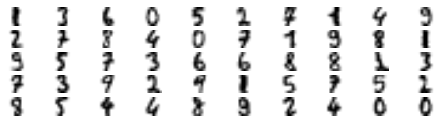

In [28]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

Ahora aplicamos etiquetas manualmente a los dígitos representativos.

In [29]:
y_representative_digits = array([1,2,6,0,5,2,7,1,4,9,
                                 2,7,8,4,0,7,1,9,8,1,
                                 9,5,7,3,6,6,8,8,1,3,
                                 7,3,9,2,9,1,5,7,5,2,
                                 8,5,4,4,8,9,2,4,0,0])

In [30]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

/home/graeme/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8844444444444445

Hemos mejorado la precisión, pero todavía tenemos solamente $50$ instancias.

El uso de etiquetas aplicadas manualmente corresponde a **aprendizaje activo** (*active learning*).

Para mejorar el modelo podemos propagar las etiquetas de las imagenes representativas a todas las instancias de los cúmulos (se llama **propagación de etiquetas**).

In [31]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [32]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

/home/graeme/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/graeme/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.9022222222222223

Aunque hemos mejorado la precisión, estamos propagando etiquetas a instancias en los límites de los cúmulos, que probablemente están mal etiquetadas.

Entonces, propagamos las etiquetas a solamente $20$% de las instancias más cercanas a los centros de los cúmulos.

In [33]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [34]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

/home/graeme/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/graeme/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8977777777777778

Las etiquetadas propagadas son bastante buenas:

In [35]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9757785467128027

### DBSCAN

Este método define un cúmulo como una región contínua de densidad alta.

* Para cada instancia el algoritmo determina cuantas instancias tienen una distancia menor que $\epsilon$ (vecindario de $\epsilon$).
* Si una instancia tiene mínimo `min_samples` instancias en su vecindario de $\epsilon$ (incluyendo si mismo) está considerado una **instancia central**.
* Todas las instancias en el vecindario de una instancia central pertenecen al mismo cúmulo. Este puede incluir más instancias centrales, así que una secuencia de instancias centrales cercanas forma un sólo cúmulo.
* Cualquiera instancia que no es una instancia central y no tiene una en su vecindario está considerada una anomalía.

El método funciona bien con cúmulos densos y bien separados por regiones de densidad baja.

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

In [37]:
X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [38]:
dbscan.labels_

array([ 0,  1,  0, -1,  0,  0, -1,  2,  2,  2,  1,  0,  0,  0,  0,  1,  3,
        2,  2, -1,  4,  4,  2,  2,  4,  4,  4,  0,  3,  2,  0,  2,  1,  3,
        3,  3,  2,  1,  5,  1,  3,  0,  1,  0,  3,  2,  3,  2,  0,  4,  0,
        0,  0,  1,  1,  1,  0,  3,  0,  2,  1,  0,  0,  0,  2,  2,  1,  0,
        1,  3, -1,  1,  2, -1,  2,  0,  2,  1,  2,  0,  0,  2,  0,  2,  0,
        2,  2,  1,  0,  1,  3,  0,  3,  3,  0,  1,  3,  1,  0,  2,  1, -1,
        3,  2,  5,  2,  1,  2,  2,  0,  0,  2,  0,  5,  0,  0, -1,  0,  0,
       -1,  3,  4,  1,  1,  0,  0, -1,  0,  2,  0,  4,  1,  2,  1, -1,  0,
        4,  1,  1,  1,  0,  0,  3,  5,  4,  1,  1,  0,  0,  0,  5,  3,  0,
        4,  1,  0,  1,  2,  3,  1,  1,  0,  2,  1,  1,  0,  3,  3, -1, -1,
        0,  2,  0,  0,  2,  2,  0,  0,  1,  5,  3,  3,  1,  1,  0,  1,  2,
        4,  0,  0,  1,  2,  2,  0,  1,  4,  1,  1,  4,  2,  1,  2,  3,  5,
        2,  3,  0,  0, -1,  5,  1,  2, -1,  0,  2,  1,  1,  2,  0,  2,  1,
        2,  2,  2,  0,  2

Las etiquetas $-1$ indican **anomalías** según el algoritmo.

Los índices de las instancias centrales están en la variable `core_sample_indices_`

Las instancias centrales están guardados en la variable `components_`

In [39]:
len(dbscan.core_sample_indices_)

818

In [40]:
dbscan.core_sample_indices_

array([  0,   1,   2,   7,   8,   9,  10,  12,  14,  15,  16,  17,  18,
        20,  21,  23,  24,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        50,  51,  53,  55,  56,  57,  58,  59,  60,  61,  65,  66,  67,
        68,  72,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  91,  93,  95,  96,  97,  98,  99, 100, 102,
       103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 117,
       120, 122, 124, 125, 127, 128, 129, 131, 132, 133, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181,
       182, 183, 186, 187, 188, 190, 191, 192, 194, 195, 196, 197, 198,
       200, 201, 203, 204, 205, 206, 207, 209, 210, 211, 213, 214, 215,
       216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 22

In [41]:
dbscan.components_

array([[-0.34735776,  0.96456059],
       [ 0.25245137, -0.12606044],
       [-0.85663687,  0.42702404],
       ...,
       [ 0.54965075,  0.90522696],
       [ 0.16202884,  0.94752182],
       [ 1.88719566,  0.0433807 ]])

Con `eps=0.05` el método identifica muchos cúmulos y muchas anomalías. Funciona mejor con `eps=0.2`.

![](figures_sin_supervision/fig9-14.png)

DBSCAN no posee un método `predict()`, solamente `fit_predict()`. Así que no puede predecir a cuál cúmulo pertenece una nueva instancia.

Podemos entrenar un clasificador para predecir instancias nuevas, usando las etiquetas determinadas por DBSCAN. Aquí usamos solamente las instancias centrales.

In [46]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.2)

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [49]:
X_new = array([[-0.5,0], [0,0.5], [1,-0.1], [2,1]])

In [50]:
knn.predict(X_new)

array([0, 1, 0, 1])

In [52]:
knn.predict_proba(X_new)

array([[0.8 , 0.2 ],
       [0.  , 1.  ],
       [0.84, 0.16],
       [0.  , 1.  ]])

In [55]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

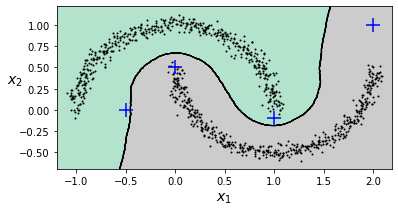

In [56]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)

El clasificador no identifica puntos como anomalías. Pero podemos usar el método `kneighbors()` para determinar las distancias entre los $k$ puntos más cercanos a las instancias nuevas.

Si hay puntos lejanos de ambos cúmulos podemos declararlos como anomalías.

In [58]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  1,  0, -1])

* DBSCAN es un método simple pero poderoso que puede identificar cualquier número de cúmulos, de cualquier forma.
* El método es robusto a anomalías y tiene solamente $2$ hiperparámetros (`eps`, `min_samples`)
* Si la densidad varia mucho en los cúmulos podría ser imposible captar todos los cúmulos correctamente.

Complejidad computacional: $\mathcal{O}(m \log m)$.

#### Otros algoritmos de *clustering*

* *Agglomerative clustering*: una jerarquía de cúmulos está construido de abajo hacia arriba. En cada iteración el par de cúmulos más cercano está conectados (comenzando con un par de instancias).

In [3]:
from sklearn.cluster import AgglomerativeClustering
?AgglomerativeClustering

* *Birch*: diseñado para conjuntos de datos muy grandes. Construye una estructura de árbol durante el entrenamiento que contiene suficiente información para asignar nuevas instancias a un cúmulo, sin la necesidad de guardar todas las instancias en el árbol.

In [5]:
from sklearn.cluster import Birch
?Birch

* *Mean-shift* (desplaza de promedio): coloca un círculo en cada instancia, calcula el promedio de todas las instancias en el círculo, desplaza el círculo al promedio. Después repite el proceso hasta que los círculos no se muevan. Los círculos tienden a encontrar máximos locales de densidad. Si hay muchos círculos que coinciden, están unidos.

In [8]:
from sklearn.cluster import MeanShift
?MeanShift

* *Affinity propagation* (propagación de afinidad): las instancias votan para que instancias similares sean sus "representativos". Cuando hay convergencia cada representativo y sus votantes forman un cúmulo.

In [10]:
from sklearn.cluster import AffinityPropagation
?AffinityPropagation

* *Spectral clustering*: considera una matriz de similitud entre las instancias y crea una "inmersión" de baja dimensionalidad. Después ocupa un algoritmo de *clustering* (*K-Means* en Scikit-Learn).

In [12]:
from sklearn.cluster import SpectralClustering
?SpectralClustering

## Modelos de mezcla gaussiana (*Gaussian Mixture Models*)

Modelo estadístico que supone que las instancias fueron generados de una mezcla de distribuciones gaussianas con parámetros desconocidos.

Cada cúmulo de puntos corresponde a una gaussiana, y típicamente se ve como un elipsoide.

Hay distintas versiones de GMM. En la versión más simple (`GaussianMixture`) hay que saber *a priori* el número $k$ de distribuciones gaussianas.

Se supone que el conjunto de datos $\boldsymbol{X}$ estaba generado a través del subsiguiente proceso probabilistico:

* Para cada instancia, se elige un cúmulo aleatoriamente entre los $k$ cúmulos. 
* La probabilidad de elegir el $j$-esima cúmulo está definido por el **peso** $\phi^{(j)}$ del cúmulo. 
* El índice del cúmulo elegido por el $i$-esima cúmulo está denotado con $z^{(i)}$.
* Si $z^{(i)} = j$ ($i$-esima instancia asignada al $j$-esima cúmulo) la ubicación $\boldsymbol{x}^{(i)}$ de esta instancia está elegida aleatoriamente de la distribución gaussiana con promedio $\boldsymbol{\mu}^{(j)}$ y matriz de covarianza $\boldsymbol{\Sigma}^{(j)}$.
* Indicamos este con $\boldsymbol{x}^{(i)} \sim \mathcal{N}\left( \boldsymbol{\mu}^{(j)}, \boldsymbol{\Sigma}^{(j)} \right)$

Podemos representar este proceso generativo con el siguiente gráfico:

![](figures_sin_supervision/fig9-16.png)

La interpretación es así:

* Los círculos representan variables aleatorias.

* Los cuadrados representan valores fijos (i.e. parámetros)

* Los rectángulos se llaman placas (*plates*): indican que sus contenidos están repetidos varias veces, el número de repeticiones indicado en la esquina abajo a la derecha.

* Cada variable $z^{(i)}$ viene de la [**distribución categórica**](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_categ%C3%B3rica) con pesos $\boldsymbol{\phi}$.

* Cada variable $\boldsymbol{x}^{(i)}$ viene de una distribución normal con promedio y matriz de covarianza definidos por su cúmulo $z^{(i)}$.

* Las flechas rectas representan dependencias condicionales. Por ejemplo, la distribución de probabilidad para cada variable aleatoria $z^{(i)}$ depende del vector de pesos $\boldsymbol{\phi}$.

* La flecha ondulada de $z^{(i)}$ a $\boldsymbol{x}^{(i)}$ representa un cambio: dependiendo del valor de $z^{(i)}$, la instancia $\boldsymbol{x}^{(i)}$ viene de una distribución normal distinta.

* Nodos sombreados indican que el valor es conocido. En este caso solamente las variables $\boldsymbol{x}^{(i)}$ tienen valores conocidos. Se llaman **variables observadas**. Las $z^{(i)}$ desconocidas se llaman **variables latentes**.

In [19]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

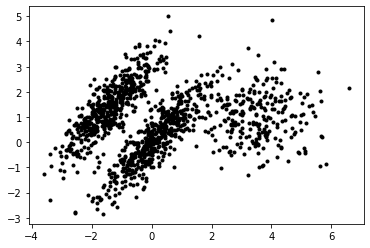

In [26]:
plot(X[:,0], X[:,1], 'k.')

In [27]:
from sklearn.mixture import GaussianMixture

In [28]:
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [29]:
gm.weights_

array([0.40009697, 0.20925194, 0.39065109])

In [30]:
gm.means_

array([[-1.40745226,  1.42727761],
       [ 3.40241777,  1.05702687],
       [ 0.05292802,  0.07720061]])

In [31]:
gm.covariances_

array([[[ 0.63518782,  0.7300408 ],
        [ 0.7300408 ,  1.16123726]],

       [[ 1.14357415, -0.02922398],
        [-0.02922398,  0.95297095]],

       [[ 0.69052478,  0.79895376],
        [ 0.79895376,  1.21568342]]])

El modelo utiliza un algoritmo de [*expectation maximization*](https://es.wikipedia.org/wiki/Algoritmo_esperanza-maximizaci%C3%B3n) para encontrar no solamente los centros de los cúmulos (e.g. los $\boldsymbol{\mu}^{(i)}$) sino que también los $\boldsymbol{\Sigma}^{(i)}$ (tamaño, forma y orientación) y sus pesos relativos ($\phi^{(i)}$).

El algoritmo implementa dos pasos

1. Expectación: asigna instancias a cúmulos
2. Maximización: actualiza los cúmulos

hasta convergencia.

In [32]:
gm.converged_

True

In [33]:
gm.n_iter_

6

In [34]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1])

In [35]:
gm.predict_proba(X)

array([[6.80542526e-07, 2.27284124e-02, 9.77270907e-01],
       [6.78281758e-04, 1.60398423e-02, 9.83281876e-01],
       [9.99922872e-01, 1.93447944e-06, 7.51931764e-05],
       ...,
       [2.19704604e-26, 9.99999561e-01, 4.39240952e-07],
       [1.52817376e-41, 1.00000000e+00, 5.39200212e-16],
       [8.29296554e-41, 1.00000000e+00, 2.33864674e-15]])

Este modelo es **generativo** - podemos crear nuevas instancias:

In [36]:
X_new, y_new = gm.sample(6)

In [37]:
X_new

array([[-0.55469969,  1.9994542 ],
       [-1.74094526,  0.25981396],
       [ 3.15580938,  1.66334135],
       [ 3.72998208,  1.07107989],
       [ 3.09448547,  1.59796752],
       [ 0.85647092,  0.86252337]])

In [38]:
y_new

array([0, 0, 1, 1, 1, 2])

También se puede estimar la densidad del modelo en cualquier posición con `score_samples()`: para cada instancia dada, el método estima el logaritmo de la función de densidad de probabilidad (PDF) en esa posición:

In [39]:
gm.score_samples(X)

array([-2.60562363, -3.57128156, -3.33045538, ..., -3.51403945,
       -4.39552047, -3.80518816])

La exponencial de estos puntajes da el valor del PDF en las ubicaciones de las instancias dadas.

In [42]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

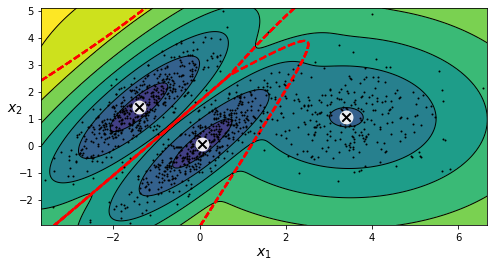

In [43]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)

Podemos regularizar el modelo (imponer restricciones para ayudar en encontrar una solución buena) especificando la forma geométrica de los cúmulos con la opción `covariance_type`:

* `"spherical"`: todos los cúmulos tienen forma esférica, pero pueden tener diámetros distintos.
* `"diag"`: cúmulos elipsoides, pero con ejes paralelos a las coordenadas (i.e. los $\boldsymbol{\Sigma}$ son diagonales)
* `"tied"`: todos los cúmulos tienen la misma forma elipsoide, tamaño y orientación (i.e. todos comparten la misma $\boldsymbol{\Sigma}$).

Por defecto, `covariance_type="full"`: sin restricciones.

Complejidad computacional: 

* `"tied"`, `"full"`: $\mathcal{O}(kmn^2 + kn^3)$
* `"spherical"`, `"diag"`: $\mathcal{O}(kmn)$

##### Detección de anomalías

Se puede clasificar cualquier instancia en una región de densidad baja como una anomalía. Hay que definir que queremos decir con "densidad baja".

In [44]:
densities = gm.score_samples(X)
density_threshold = percentile(densities, 4)
anomalies = X[densities < density_threshold]

In [45]:
anomalies

array([[-0.11118987,  1.61334992],
       [ 0.62362922,  4.41540435],
       [ 1.49808977, -0.15251688],
       [ 0.74219223, -1.00445177],
       [-2.53940854, -2.76549965],
       [-1.62447969, -0.45770022],
       [-1.74680316, -0.78385111],
       [-3.58308316, -1.28249917],
       [ 0.53903026,  5.00244257],
       [-0.51480414, -2.16270124],
       [-1.81015204, -0.58926015],
       [-1.79651788, -0.97031471],
       [-2.11225785, -2.09712817],
       [-3.39408574, -2.28378778],
       [ 1.58082729,  4.20122873],
       [-2.48037945, -1.18651064],
       [-2.93972237, -1.41660564],
       [-1.62285961, -2.84860478],
       [-0.25954463, -1.7743691 ],
       [ 0.46018217,  2.78323717],
       [-2.06317379,  2.2670332 ],
       [ 0.13982849,  2.08023553],
       [-2.54004484, -2.8290338 ],
       [-1.93037427, -1.19447352],
       [-0.27124433, -1.86750177],
       [-1.15568262, -2.57480367],
       [-1.93315582,  2.49030105],
       [ 4.93207567, -0.42157602],
       [ 5.80546094,

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

#### Eligiendo el número de cúmulos

Para modelos de mezcla gaussiana podemos encontrar el modelo mejor por minimización de un **criterio teórico de información**:

Criterio de información Bayesiano (BIC): $\log(m)p - 2\log(\hat{L})$

Criterio de información Akaike (AIC): $2p - 2\log(\hat{L})$.

* $m$ es el número de instancias (como siempre)
* $p$ es el número de parámetros aprendidos por el modelo
* $\hat{L}$ es el valor maximizado de la **función de verosimilitud** del modelo (*likelihood function*)

BIC y AIC penalizan modelos con más parámetros para aprender (e.g. más cúmulos) y premian modelos que ajustan bien a los datos.

BIC tiende a preferir modelos más simples. AIC tiende a preferir modelos que ajustan mejor a los datos.

#### Una desviación para ver más sobre la función de versosimilitud

Consideremos un modelo unidimensional con $2$ distribuciones gaussianas centradas en $-4$ y $+1$. Para simplificar, el modelo tiene un sólo parámetro $\theta$ que determina las desviaciones estandares de ambas distribuciones.

![](figures_sin_supervision/fig9-20a.png)

Para estimar la probabilidad de un valor de $x$, necesitamos fijar el valor de $\theta$. Por ejemplo, con $\theta = 1.3$ (línea horizontal) tenemos la PDF $f(x;\theta=1.3)$ mostrada abajo:

![](figures_sin_supervision/fig9-20b.png)

La probabilidad de tener $-2 \leq x \leq 2$ está dada por la integral de la curva entre esos límites (área sombreado).

Al contrario, si observamos una sóla instancia $x=2.5$ (línea vertical en el gráfico del modelo) obtenemos la función de verosimilitud (*likelihood function*) $\mathcal{L}(\theta | x=2.5) = f(x=2.5;\theta)$.

![](figures_sin_supervision/fig9-20c.png)

Entonces, la PDF es una función de $x$ (con $\theta$ fija), mientras la función de verosimilitud es una función de $\theta$ (con $x$ fija).

Es importante entender que la función de verosimilitud NO es una distribución de probabilidad! La integral de una PDF sobre todo $x$ es igual a $1$. La integral de la función de verosimilitud sobre todo $\theta$ puede ser cualquier valor positivo.

Dado un conjunto de datos $\boldsymbol{X}$, muchas veces queremos estimar los valores más probables de los parámetros del modelo.

Entonces, queremos maximizar la función de verosimilitud, dado $\boldsymbol{X}$. En este ejemplo, con $x=2.5$, la **estimación de máxima verosimilitud** (*maximum likelihood estimate*) de $\theta$ es $\hat{\theta} = 1.5$.

Si ya existe una distribución de probabilidad $g(\theta)$ para $\theta$, se puede tomarla en consideración maximizando $\mathcal{L}(\theta | x)g(\theta)$ en vez de solamente $\mathcal{L}(\theta | x)$. Se llama **estimación de máxima *a posteriori***.

Es equivalente maximizar la verosimilitud o el logaritmo del mismo:

![](figures_sin_supervision/fig9-20d.png)

El logaritmo es una función que siempre crece, así que si $\hat{\theta}$ maximiza el logaritmo de $\mathcal{L}$, también maximiza $\mathcal{L}$.

Típicamente es más fácil maxmimizar el logaritmo de la verosimilitud. Por ejemplo, si tenemos varias instancias $x^{(1)} \ldots x^{(m)}$ tendríamos que encontrar la $\theta$ que maximiza el **producto** de las $m$ funciones de verosimilitud individuales. Es equivalente (y más fácil) maximizar la suma del logaritmo de la verosimilitud (ya que $\log(ab) = \log(a) + \log(b)$).

Una vez que contamos con $\hat{\theta}$ (el valor de $\theta$ que maximiza $\mathcal{L}(\theta | x)$) podemos determinar $\hat{L} = \mathcal{L}(\hat{\theta} | x)$ y calcular el AIC y/o BIC.

In [1]:
gm.bic(X)

NameError: name 'gm' is not defined

In [2]:
gm.aic(X)

NameError: name 'gm' is not defined

![](figures_sin_supervision/fig9-21.png)

#### Modelos bayesianos de mezcla gaussiana

La clase `BayesianGaussianMixture` es capaz de dar pesos igual (o cerca) a cero para los cúmulos no necesarios.

Hay que elegir un valor para `n_components` mayor que el número óptimo de cúmulos y el modelo eliminará los cúmulos no necesarios automáticamente.

In [3]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
np.round(bgm.weights_, 2)

NameError: name 'X' is not defined

En este modelo los parámetros de los cúmulos no son fijos sino que variables aleatorias latentes.

![](figures_sin_supervision/fig9-22.png)

Conociemiento previo de las variables latentes $\boldsymbol{z}$ puede ser incluido en una distribución de probabilidad $p(\boldsymbol{z})$ que se llama la **previa** (*prior*).

Por ejemplo, quizás pensamos que hay pocos cúmulos (concentración baja) o que hay muchos (concentración alta). Se puede ajustar esta información con el hiperparámetro `weight_concentration_prior`.

![](figures_sin_supervision/fig9-23.png)

Con más datos los *priors* importan menos. De hecho, para ver diferencias tan grandes como en el gráfico arriba hay que usar *priors* muy fuertes y pocos datos.

El teorema de Bayes indica como actualizar la distribución de probabilidad sobre las variables latentes después de observar los datos $\boldsymbol{X}$. Calcula la distribución **posterior** $p(\boldsymbol{z}|\boldsymbol{X})$, que es la probabilidad condicional de $\boldsymbol{z}$ dado $\boldsymbol{X}$.

$$p(\boldsymbol{z}|\boldsymbol{X}) = \text{Posterior} = \frac{\text{Verosimilitud} \times \text{Prior}}{\text{Evidencia}} = \frac{p(\boldsymbol{X}|\boldsymbol{z})p(\boldsymbol{z})}{p(\boldsymbol{X})}$$

El problema es el denominador...

$$p(\boldsymbol{X}) = \int p(\boldsymbol{X} | \boldsymbol{z})p(\boldsymbol{z})d\boldsymbol{z}$$

Este requiere una integración sobre todos los valores posibles de $\boldsymbol{z}$, es decir, todas las posibles combinaciones de parámetros y asignaciones de cúmulos.

Calcular esta cantidad es uno de los problemas centrales de la estadística bayesiana. Hay varios métodos para hacerlo:

##### Inferencia variacional

Elegimos una familia de distribuciones $q(\boldsymbol{z};\boldsymbol{\lambda})$ (con parámetros variacionales $\boldsymbol{\lambda}$) y optimizamos estos parámetros tal que $q(\boldsymbol{z})$ sea una aproximación buena de $p(\boldsymbol{z} | \boldsymbol{X})$.

Logramos esto por encontrar el valor de $\boldsymbol{\lambda}$ que minimiza la divergencia KL (Kullback-Leibler) de $q(\boldsymbol{z})$ a $p(\boldsymbol{z}|\boldsymbol{X})$, denoted $D_{KL}(q||p)$.

$$\begin{split} D_{KL}(q||p) &= \mathbb{E}_q \left[ \log \frac{q(\boldsymbol{z})}{p(\boldsymbol{z} | \boldsymbol{X})} \right] \\ &= \mathbb{E}_q \left[ \log q(\boldsymbol{z}) - \log p(\boldsymbol{z} | \boldsymbol{X}) \right] \\ &= \mathbb{E}_q \left[ \log q(\boldsymbol{z}) - \log \frac{p(\boldsymbol{z},\boldsymbol{X})}{p(\boldsymbol{X})} \right] \\ &= \mathbb{E}_q [ \log q(\boldsymbol{z})] - \mathbb{E}_q [\log p(\boldsymbol{z},\boldsymbol{X})] + \mathbb{E}_q [\log p(\boldsymbol{X})] \\ &= \mathbb{E}_q [ \log p(\boldsymbol{X})] - \left( \mathbb{E}_q [\log p(\boldsymbol{z},\boldsymbol{X})] - \mathbb{E}_q [\log q(\boldsymbol{z})] \right) \\ &= \log p(\boldsymbol{X}) - \text{ELBO} \end{split}$$

donde $\text{ELBO} = \mathbb{E}_q [\log p(\boldsymbol{z},\boldsymbol{X})] - \mathbb{E}_q [\log q(\boldsymbol{z})]$.

ELBO significa *evidence lower bound*.

El término $\log p(\boldsymbol{X})$ no depende de $q$, así que es una constante (en el problema de variación de $q$) y la minimización de KL solamente requiere la **maximización** del ELBO.

En la práctica hay varias técnicas para maximizar el ELBO. En *mean field variational inference* hay que elegir la familia $q(\boldsymbol{z};\boldsymbol{\lambda})$ y la *prior* $p(\boldsymbol{z})$ muy cuidadosamente para asegurar que la ecuación para el ELBO simplifique suficientemente para calcularla!

No hay una forma general para hacer esto (y es difícil). En `BayesianGaussianMixture` de Scikit-Learn la documentación explica la implementación.

Un método más simple para maximizar el ELBO se llama *black box stochastic variational inference* (BBSVI): en cada iteración se extraen algunas muestras de $q$ y están usadas para estimar los gradientes del ELBO con respecto a los parámetros $\boldsymbol{\lambda}$. Después se aplica un **ascenso por gradiente**.

Con este método se puede utilizar inferencia bayesiana con cualquier modelo (si es diferenciable), incluso redes neuronales profundas: **aprendizaje profundo bayesiano** (*Bayesian deep learning*).

#### El algoritmo de *expectation maximization*

Volvemos al algoritmo usado para entrenar el modelo de mezcla gaussiana.

Consideremos como ejemplo un modelo que mezcla dos distribuciones normales multivariadas de dimensión $d$.

$\boldsymbol{x} = (\boldsymbol{x}_1,\boldsymbol{x}_2,\ldots,\boldsymbol{x}_n)$ es una muestra de $n$ instancias extraidas de ese modelo (ojo: cada instancia es un vector en un espacio de $d$ dimensiones!)

$\boldsymbol{z} = (z_1,z_2,\ldots,z_n)$ son las variables latentes que determinan el componente del cuál proviene cada instancia.

* $\boldsymbol{x}_i | (z_i = 1) \sim \mathcal{N}_d(\boldsymbol{\mu}_1,\Sigma_1)$
* $\boldsymbol{x}_i | (z_i = 2) \sim \mathcal{N}_d(\boldsymbol{\mu}_2,\Sigma_2)$

donde $p(z_i = 1) = \tau_1$ y $p(z_i = 2) = \tau_2 = 1 - \tau_1$.

La meta es estimar los parámetros desconocidos que representan las dos distribuciones y su mezcla:

$\theta = (\boldsymbol{\tau},\boldsymbol{\mu}_1,\boldsymbol{\mu}_2,\Sigma_1,\Sigma_2)$

donde la función de verosimilitud de **datos incompletos** es

$L(\theta;\boldsymbol{x}) = \prod_{i=1}^n \sum_{j=1}^2 \tau_j f(\boldsymbol{x}_i;\boldsymbol{\mu}_j,\Sigma_j)$

y la función de verosimilitud de **datos completos** es

$L(\theta;\boldsymbol{x},\boldsymbol{z}) = p(\boldsymbol{x},\boldsymbol{z} | \theta) = \prod_{i=1}^n \prod_{j=1}^2 [f(\boldsymbol{x}_i;\boldsymbol{\mu}_j,\Sigma_j)\tau_j]^{\mathbb{I}(z_i=j)}$

La función $\mathbb{I}$ es una función indicadora:

$$\mathbb{I}(z_i = j) = \begin{cases} 1 & z_i = j \\ 0 & z_i \neq j \end{cases}$$

$f$ es la función de densidad de probabilidad de una distribución normal mutlivariada.

Se puede escribir la última función como

$L(\theta; \boldsymbol{x}, \boldsymbol{z}) = \exp \left\{ \sum_{i=1}^n \sum_{j=1}^2 \mathbb{I}(z_i=j)[\log \tau_j - \frac{1}{2}\log |\Sigma_j| - \frac{1}{2}(\boldsymbol{x}_i-\boldsymbol{\mu}_j)^T \Sigma_j^{-1}(\boldsymbol{x}_i - \boldsymbol{\mu}_j) - \frac{d}{2}\log(2\pi) \right\}$.

##### Primera parte: esperanza (expectation)

Dada nuestra estimación actual de los parámetros (pueden comenzar con valores aleatorios) $\theta^{(t)}$, la probabilidad condicional de los $z_i$ está determinada por el teorema de Bayes:

$$T_{j,i}^{(t)} := P(z_i=j|\boldsymbol{x}_i;\theta^{(t)}) = \frac{\tau_j^{(t)} f(\boldsymbol{x}_i;\boldsymbol{\mu}_j^{(t)},\Sigma_j^{(t)})}{\tau_1^{(t)}f(\boldsymbol{x}_i;\boldsymbol{\mu}_1{(t)},\Sigma_1^{(t)}) + \tau_2^{(t)}f(\boldsymbol{x}_i;\boldsymbol{\mu}_2^{(t)},\Sigma_2^{(t)})}$$

Ahora, determinamos el valor de esperanza del logaritmo de la función de verosimilitud (llamado $Q$):

$$\begin{split} Q(\theta | \theta^{(t)}) &= \mathbb{E}_{\boldsymbol{z}|\boldsymbol{x},\theta^{(t)}}[\log L(\theta;\boldsymbol{x},\boldsymbol{z})] \\
&= \mathbb{E}_{\boldsymbol{z}|\boldsymbol{x},\theta^{(t)}}[\log \prod_{i=1}^n L(\theta;\boldsymbol{x}_i,z_i)] \\
&= \mathbb{E}_{\boldsymbol{z}|\boldsymbol{x},\theta^{(t)}}[\sum_{i=1}^n \log L(\theta;\boldsymbol{x}_i,z_i)] \\
&= \sum_{i=1}^n \mathbb{E}_{z_i|\boldsymbol{x},\theta^{(t)}}[\log L(\theta;\boldsymbol{x}_i,z_i)] \\
&= \sum_{i=1}^n \sum_{j=1}^2 p(z_i=j|\boldsymbol{x}_i;\theta^{(t)}) \log L(\theta_j;\boldsymbol{x}_i,j) \\
&= \sum_{i=1}^n \sum_{j=1}^2 T_{j,i}^{(t)} [\log \tau_j - \frac{1}{2}\log |\Sigma_j| - \frac{1}{2}(\boldsymbol{x}_i-\boldsymbol{\mu}_j)^T \Sigma_j^{-1}(\boldsymbol{x}_i - \boldsymbol{\mu}_j) - \frac{d}{2}\log(2\pi)] \end{split}$$

Todo lo que necesitamos para calcular la cantidad arriba está conocido, aparte de los $T_{j,i}^{(t)}$, que están calculados al principio de esta parte del algoritmo.

##### Segunda parte: maximización

Ya que $Q(\theta | \theta^{(t)})$ toma una forma cuadrática se puede encontrar los valores de $\theta$ que la maximiza sin mucha dificultad.

Para los $\boldsymbol{\tau}$ (sujetos a la restricción $\tau_1 + \tau_2 = 1$) tenemos:

$$\begin{split} \boldsymbol{\tau}^{(t+1)} &= \underset{\boldsymbol{\tau}}{\text{argmax}} Q(\theta | \theta^{(t)}) \\
&= \underset{\boldsymbol{\tau}}{\text{argmax}} \left\{ \left[ \sum_{i=1}^n T_{1,i}^{(t)} \right] \log \tau_1 + \left[ \sum_{i=1}^n T_{2,i}^{(t)} \right] \log \tau_2 \right\} \end{split}$$

Esta tiene la misma forma que la estimación de máxima verosimilitud (*maximum likelihood estimate*, MLE) para la distribución binomial, por lo tanto:

$$\tau_j^{(t+1)} = \frac{\sum_{i=1}^n T_{j,i}^{(t)}}{\sum_{i=1}^n (T_{1,i}^{(t)} + T_{2,i}^{(t)})} = \frac{1}{n}\sum_{i=1}^n T_{j,i}^{(t)}$$

Para $(\boldsymbol{\mu}_1,\Sigma_1)$:

$$\begin{split} (\boldsymbol{\mu}_1^{(t+1)}, \Sigma_1^{(t+1)}) &= \underset{\boldsymbol{\mu}_1, \Sigma_1}{\text{argmax}} Q(\theta | \theta^{(t)}) \\
&= \underset{\boldsymbol{\mu}_1, \Sigma_1}{\text{argmax}} \sum_{i=1}^n T_{1,i}^{(t)} \left\{ -\frac{1}{2}\log |\Sigma_1| - \frac{1}{2}(\boldsymbol{x}_i - \boldsymbol{\mu}_1)^T \Sigma_1^{-1}(\boldsymbol{x}_i - \boldsymbol{\mu}_1) \right\} \end{split}$$

Esta tiene la misma forma que la MLE ponderada de una distribución normal:

$$\boldsymbol{\mu}_1^{(t+1)} = \frac{\sum_{i=1}^n T^{(t)}_{1,i} \boldsymbol{x}_i}{\sum_{i=1}^n T_{1,i}^{(t)}} \; \; \; \Sigma_1^{(t+1)} = \frac{\sum_{i=1}^n T^{(t)}_{1,i}(\boldsymbol{x}_i-\boldsymbol{\mu}_1^{(t+1)})(\boldsymbol{x}_i-\boldsymbol{\mu}_1^{(t+1)})^T}{\sum_{i=1}^n T_{1,i}^{(t)}}$$

Por simetría:

$$\boldsymbol{\mu}_2^{(t+1)} = \frac{\sum_{i=1}^n T^{(t)}_{2,i} \boldsymbol{x}_i}{\sum_{i=1}^n T_{2,i}^{(t)}} \; \; \; \Sigma_2^{(t+1)} = \frac{\sum_{i=1}^n T^{(t)}_{2,i}(\boldsymbol{x}_i-\boldsymbol{\mu}_2^{(t+1)})(\boldsymbol{x}_i-\boldsymbol{\mu}_2^{(t+1)})^T}{\sum_{i=1}^n T_{2,i}^{(t)}}$$

##### Terminación de las iteraciones

Criterio: $\mathbb{E}_{\boldsymbol{z}|\theta^{(t)},\boldsymbol{x}} [\log L(\theta^{(t)};\boldsymbol{x},\boldsymbol{z}] \leq \mathbb{E}_{\boldsymbol{z}|\theta^{(t-1)},\boldsymbol{x}} [\log L(\theta^{(t-1)};\boldsymbol{x},\boldsymbol{z}] + \epsilon$ donde $\epsilon$ es algún umbral pre-determinado.

##### Limitaciones de modelos de mezcla gaussiana

Si los cúmulos no tienen forma elipsoide, los resultados pueden ser malos...

![](figures_sin_supervision/fig9-24.png)

### Otros algoritmos para detección de anomalías/novedades

* *Fast-MCD (*minimum covariance determinant*): implementado en Scikit-Learn por la clase `EllipticEnvelope`. El modelo supone que las instancias normales vienen de una sóla distribución gaussiana, y que hay contaminación de anomalías que NO vienen de una distribución gaussiana.

![](figures_sin_supervision/elliptic_envelope.png)

* *Isolation Forest*: construye un *random forest* donde cada árbol es totalmente aleatorio. Eventualmente todas las instancias están aisladas una de otra. Una anomalía es más lejana de las otras instancias, así que está aislada en menos iteraciones.

![](figures_sin_supervision/isolation_forest.png)

* *Local outlier factor*: compara la densidad de las instancias alrededor de una instancia con la densided alrededor de sus vecinas. Una anomalía es típicamente más aislada que sus $k$ vecinas.

![](figures_sin_supervision/LOF.png)

* *One-class SVM*: un SVM con *kernel* intenta separar dos clases por mapear las instancias a un espacio de alta dimensionalidad y después encontrar un hiperplano en ese espacio que separa las clases.

Con una sóla clase de instancias, este algoritmo intenta separar las instancias en el espacio de alta dimensionalidad del origen. En el espacio original este corresponde a encontrar una región pequeña que engloba todas las instancias. Si una instancia nueva no se ubica en esa región cuenta como una anomalía.

![](figures_sin_supervision/one_class_svm.png)